In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

from tqdm import tqdm

In [2]:
data = np.load('processed_ntuples/chunking/chunk_nonu_data.npy')
np.shape(data)

(527375, 33)

In [3]:
train, val = train_test_split(data, random_state=137) # setting the seed for reproducibility; the default train/test split is 0.75/0.25
print('lenght of training set', len(train), '\nlenght of validation set', len(val), '\nwidth of the sets: # of features + 1 flag (1-LL/0-TX)', len(train[0]))

lenght of training set 395531 
lenght of validation set 131844 
width of the sets: # of features + 1 flag (1-LL/0-TX) 33


In [4]:
# strip the last feature (e.g. the flag) from the sets

# first line check
print('first train line, before flag-stripping', train[0])

# copy in dedicated arrays
flags_train = train[:, -1]
flags_val = val[:, -1]
# delete from the sets
train = train[:, :-1]
val = val[:, :-1]
# width check
print('width of the samples, after flag-stripping', len(train[0]), len(val[0]))
# first line check
print('first train line, after flag-stripping', train[0])

first train line, before flag-stripping [ 0.45906499 -0.12419549  1.25075436  0.60235751 -0.59819829  0.27543196
 -1.07793952 -2.49373044  1.04359678 -1.1872246   1.79323445 -0.01288755
 -1.31579649 -2.24224946  1.86085179 -0.55318785 -0.36724764  0.91230302
  0.03663595 -0.2697674   0.92358258 -1.12239482 -1.80520892 -1.0771277
 -1.10550845  1.77859855  1.08062931  0.54832254  0.24672216  0.56147322
  0.78072666  0.41909306  0.        ]
width of the samples, after flag-stripping 32 32
first train line, after flag-stripping [ 0.45906499 -0.12419549  1.25075436  0.60235751 -0.59819829  0.27543196
 -1.07793952 -2.49373044  1.04359678 -1.1872246   1.79323445 -0.01288755
 -1.31579649 -2.24224946  1.86085179 -0.55318785 -0.36724764  0.91230302
  0.03663595 -0.2697674   0.92358258 -1.12239482 -1.80520892 -1.0771277
 -1.10550845  1.77859855  1.08062931  0.54832254  0.24672216  0.56147322
  0.78072666  0.41909306]


In [5]:
# tensorize the data, so that pytorch doesn't whine
train = torch.tensor(train, dtype=torch.float32)
val = torch.tensor(val, dtype=torch.float32)
flags_train = torch.tensor(flags_train, dtype=torch.float32)
flags_val = torch.tensor(flags_val, dtype=torch.float32)

In [6]:
# creation of the model class
# (don't know if the sigmoid is defined in the best way possibile; this one just works)
class myModel(nn.Module):
    def __init__(self):
        super(myModel, self).__init__()
        self.dense1 = nn.Linear(32, 64)
        self.BatchNorm1d1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.dense2 = nn.Linear(64, 48)
        self.BatchNorm1d2 = nn.BatchNorm1d(48)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.dense3 = nn.Linear(48, 32)
        self.BatchNorm1d3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)
        self.dense4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.dense1(x)
        x = self.BatchNorm1d1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.BatchNorm1d2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.dense3(x)
        x = self.BatchNorm1d3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.dense4(x)
        x = self.sigmoid(x)
        return x

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None

    def early_stop(self, validation_loss):
        score = -validation_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_score = score
            self.counter = 0
        return False

In [8]:
model = myModel()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

loss_function = nn.BCELoss() # CrossEntropyLoss but for just one class
learning_rate = 5.e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # how much the learning rate matter? the default one is 0.001

# Early stopping
early_stopping = EarlyStopping(patience=5, delta=0.01)

7121


In [9]:
# training
losses = []
val_losses = []
accuracies = []
val_accuracies = []
n_epochs = 60
batch_size = 100 # size of each batch
batch_start = torch.arange(0, len(train), batch_size)

for epoch in range(n_epochs):

    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            loss_sum = 0.
            acc_sum = 0.
            for start in bar:
                # take a batch
                train_batch = train[start:start+batch_size]
                flags_train_batch = flags_train[start:start+batch_size]
                # forward pass
                outputs = model(train_batch)
                loss = loss_function(outputs, flags_train_batch.unsqueeze(0).T)
                loss_sum += loss
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (outputs.round() == flags_train_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
                acc_sum += float(acc)
    #print(len(bar))
    loss = loss_sum / len(bar)
    losses.append(loss)
    acc = acc_sum / len(bar)
    accuracies.append(acc)

    model.eval()
    with torch.no_grad():
        val_outputs = model(val)
        val_loss = loss_function(val_outputs, flags_val.unsqueeze(0).T)
        val_losses.append(val_loss)
        val_accuracy = float((val_outputs.round().T == flags_val).float().mean())
        val_accuracies.append(val_accuracy)
    
    # Early Stopping
    if early_stopping.early_stop(val_loss):
        print(f'Early stopped at epoch: {epoch}')
        n_epochs = epoch+1
        break

    print(f'Epoch: {epoch}, Loss: {loss:.3f}, Validation Loss: {val_loss:.3f}')

Epoch: 0, Loss: 0.574, Validation Loss: 0.422
Epoch: 1, Loss: 0.374, Validation Loss: 0.235
Epoch: 2, Loss: 0.300, Validation Loss: 0.192
Epoch: 3, Loss: 0.269, Validation Loss: 0.173
Epoch: 4, Loss: 0.247, Validation Loss: 0.162
Epoch: 5, Loss: 0.235, Validation Loss: 0.151
Epoch: 6, Loss: 0.226, Validation Loss: 0.144
Epoch: 7, Loss: 0.219, Validation Loss: 0.143
Epoch: 8, Loss: 0.213, Validation Loss: 0.136
Epoch: 9, Loss: 0.208, Validation Loss: 0.134
Epoch: 10, Loss: 0.204, Validation Loss: 0.136
Epoch: 11, Loss: 0.199, Validation Loss: 0.130
Epoch: 12, Loss: 0.193, Validation Loss: 0.126
Epoch: 13, Loss: 0.188, Validation Loss: 0.118
Epoch: 14, Loss: 0.187, Validation Loss: 0.119
Epoch: 15, Loss: 0.184, Validation Loss: 0.118
Epoch: 16, Loss: 0.183, Validation Loss: 0.115
Epoch: 17, Loss: 0.180, Validation Loss: 0.114
Early stopped at epoch: 18


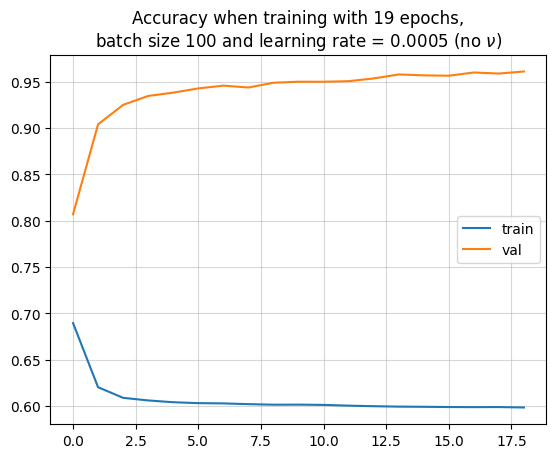

In [10]:
plt.plot(list(range(n_epochs)), accuracies, label='train')
plt.plot(list(range(n_epochs)), val_accuracies, label='val')
plt.title(f'Accuracy when training with {n_epochs} epochs,\nbatch size {batch_size} and learning rate = {learning_rate} (no $\\nu$)')
plt.grid(alpha=0.5)
plt.legend()
plt.savefig(f'acc_ctcsthrptnonu-model.png')

In [11]:
# transform the tensors to numpy for plotting
losses = np.array([l.detach().numpy() for l in losses])
val_losses = np.array([l.detach().numpy() for l in val_losses])

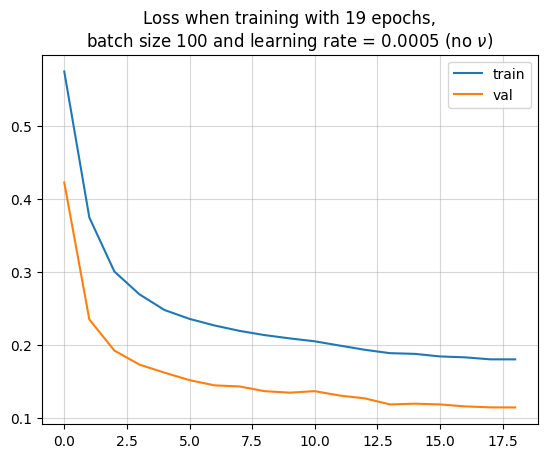

In [12]:
plt.plot(list(range(n_epochs)), losses, label='train')
plt.plot(list(range(n_epochs)), val_losses, label='val')
plt.title(f'Loss when training with {n_epochs} epochs,\nbatch size {batch_size} and learning rate = {learning_rate} (no $\\nu$)')
plt.grid(alpha=0.5)
plt.legend()
plt.savefig(f'loss_ctcsthrptnonu-model.png')

In [13]:
# transform the tensors to numpy for plotting
val_outputs = val_outputs.detach().numpy()
flags_val = flags_val.detach().numpy()

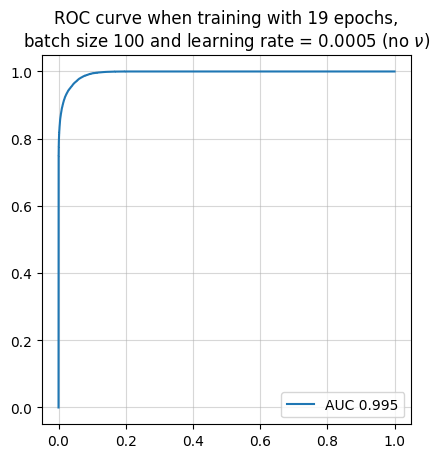

In [14]:
fpr, tpr, thresholds = roc_curve(flags_val, val_outputs)

auc = roc_auc_score(flags_val, val_outputs)

plt.plot(fpr, tpr, label=f'AUC {auc:.3f}')
plt.title(f'ROC curve when training with {n_epochs} epochs,\nbatch size {batch_size} and learning rate = {learning_rate} (no $\\nu$)')
plt.grid(alpha=0.5)
plt.legend()
plt.axis('square')
plt.savefig(f'ROC_ctcsthrptnonu-model.png')

In [15]:
sig = val_outputs[flags_val.T.astype(bool)]
bkg = val_outputs[~flags_val.T.astype(bool)]

In [16]:
# valarray = np.array([val_outputs.T[0], flags_val])
# print(valarray, np.shape(valarray))
# print(len(val_outputs), len(flags_val), len(sig), len(bkg), len(sig) + len(bkg))
# np.save(f"val_ctwnu-m.npy", valarray)
# arr = np.load('val_ctwnu-m.npy')
# print(np.shape(arr))

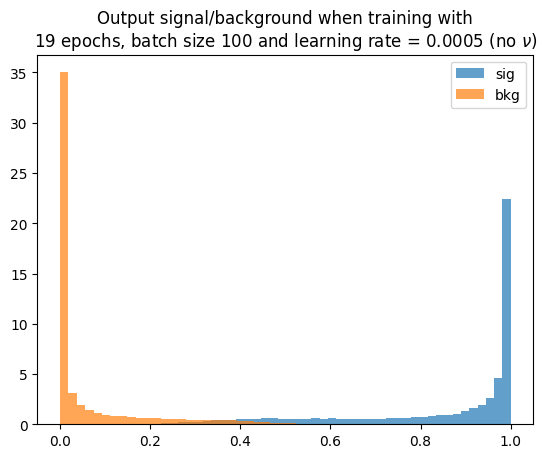

In [17]:
plt.hist(sig, bins=50, density=True, alpha=0.7, label='sig')
plt.hist(bkg, bins=50, density=True, alpha=0.7, label='bkg')
plt.title(f'Output signal/background when training with\n{n_epochs} epochs, batch size {batch_size} and learning rate = {learning_rate} (no $\\nu$)')
plt.legend()
plt.savefig(f'output_ctcsthrptnonu-model.png')

In [18]:
#torch.save(model.state_dict(), 'ctwnu-model_dict.pt')
torch.save(model, 'ctcsthrptnonu-model.pt')

In [19]:
#